# Experiments

2022.6.2 New
- Update model training with murine data, do some experiments.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from experiment_track import CDRGenerate, Metrics
from data import DataCollator, PairedBinder
from torch.utils.data import DataLoader
from model import Transformer
from params import GetParams
from typing import Dict
import numpy as np
import os
from transformers import BertTokenizer, BertModel
import time
from tqdm import tqdm
import torch
import pickle
plt.rcParams['font.sans-serif'] = ['Arial Rounded MT Bold']

# type hint
from typing import AnyStr

In [10]:
collator_fn = DataCollator()
params = GetParams("./setting.yaml").model_params()
current_model = model_loader("./experiment_outs/06-20-10-35-19/checkpoints/epoch=1984-step=190560.ckpt", params)  # murine

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False,
                                            cache_dir='../absolute_antibody/cache_model')
pretrained_model = BertModel.from_pretrained("Rostlab/prot_bert",
                                                cache_dir='../absolute_antibody/cache_model')
current_model.eval()

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Transformer(
  (decoder): Decoder(
    (aa_embedding): Embedding(22, 1024)
    (position_embedding): SinCosPositionalEncoding()
    (layers): ModuleList(
      (0): DecoderBlock(
        (attention): SelfAttention(
          (key): Linear(in_features=128, out_features=128, bias=False)
          (query): Linear(in_features=128, out_features=128, bias=False)
          (value): Linear(in_features=128, out_features=128, bias=False)
          (fc_out): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder_block): EncoderBlock(
          (attention): SelfAttention(
            (key): Linear(in_features=128, out_features=128, bias=False)
            (query): Linear(in_features=128, out_features=128, bias=False)
            (value): Linear(in_features=128, out_features=128, bias=False)
            (fc_out): Linear(in_features=1024, out_features=1024, bias=False)
          )
          (norm1): La

In [7]:
amino_vocab = {'B': 1,  # for begin
               'A': 2,
               'C': 3,
               'D': 4,
               'E': 5,
               'F': 6,
               'G': 7,
               'H': 8,
               'I': 9,
               'K': 10,
               'L': 11,
               'M': 12,
               'N': 13,
               'P': 14,
               'Q': 15,
               'R': 16,
               'S': 17,
               'T': 18,
               'V': 19,
               'W': 20,
               'Y': 21,
               'J': 22,  # for end
               }

In [8]:
# some functions, write in utils.py later!


def model_loader(ckpt, model_params: Dict):
    """Model loading""" 
    return Transformer().load_from_checkpoint(ckpt, **model_params)

def get_antigen_embedding(antigen: AnyStr, batched='True'):
    """Get antigen embedding using pre-trained model"""
    antigen_seq = ' '.join(list(antigen))
    antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                    return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
    if batched == 'True':
        return antigen_encode.unsqueeze(0)  # [1(batch), length, dim]
    return antigen_encode

def get_antibody_tokens(antibody: AnyStr, batched='True'):
    """Transfer antibody string as tensor tokens"""
    ab_token = torch.from_numpy(np.array(list(map(lambda x: amino_vocab[x], list('B' + antibody)))))
    if batched=='True':
        return ab_token.unsqueeze(0)
    return ab_token

In [15]:
# load all data
data = pickle.load(open("../absolute_antibody/paired_data/paired_abag_data.pkl", 'rb'))

## 1.perplexity of 15 held-out antigen

- list named 'a' is a list of testing ids

In [11]:
a, b = [], []  # a is a list of test ids
per_seq = []
for i in os.listdir("../experiments_data/test_split"):
    data = PairedBinder('test','murine',"../experiments_data/test_split/" + i)
    loader = next(iter(DataLoader(data, batch_size=10000000, collate_fn=collator_fn)))
    metrics = Metrics(model=current_model, loader=loader)
    mean_loss = metrics.perplexity()
    perp = np.exp(mean_loss)
    mean_perp = np.exp(np.mean(mean_loss))
    per_seq.append(perp)
    print(f"PDB: {i[:6]}, Max perp: {np.max(perp):4f}, Mean perp: {np.min(perp):4f}, Average perp: {np.mean(mean_perp):4f}")
    a.append(i[:6])
    b.append(np.mean(mean_perp))


PDB: 1OSP_O, Max perp: 20.325318, Mean perp: 1.447326, Average perp: 2.982188
PDB: 1S78_B, Max perp: 95.662767, Mean perp: 1.409012, Average perp: 2.754146
PDB: 1YJD_C, Max perp: 156.129142, Mean perp: 1.424385, Average perp: 3.585874
PDB: 1ZTX_E, Max perp: 20.193993, Mean perp: 1.376817, Average perp: 2.151325
PDB: 2R0K_A, Max perp: 653.556215, Mean perp: 1.418789, Average perp: 4.000177
PDB: 3TT1_A, Max perp: 306.550592, Mean perp: 1.365007, Average perp: 2.006330
PDB: 3U9P_C, Max perp: 78.411972, Mean perp: 1.408891, Average perp: 3.122075
PDB: 4I18_R, Max perp: 57.697422, Mean perp: 1.431664, Average perp: 2.371388
PDB: 4N9G_C, Max perp: 194.734011, Mean perp: 1.417677, Average perp: 2.525595
PDB: 4U6V_A, Max perp: 1651.581641, Mean perp: 1.299984, Average perp: 2.397093
PDB: 5EII_G, Max perp: 76.030118, Mean perp: 1.424640, Average perp: 4.650084
PDB: 5H35_C, Max perp: 514.564761, Mean perp: 1.403920, Average perp: 4.459358
PDB: 5HDQ_A, Max perp: 8.674643, Mean perp: 1.363047, Ave

In [12]:
seqs_all = pickle.load(open("../experiments_data/15_generated_sequences_700.pkl", 'rb'))

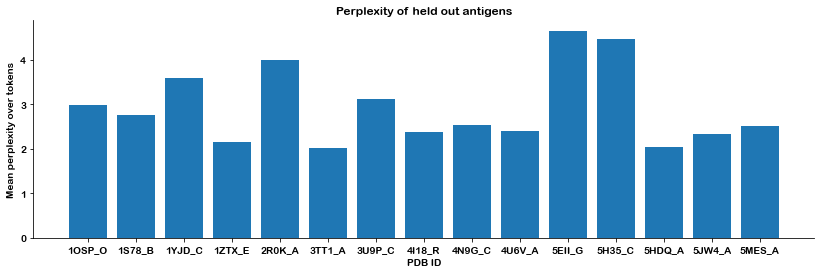

In [6]:
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(a, b)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Perplexity of held out antigens")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("PDB ID")
ax.set_ylabel("Mean perplexity over tokens")
fig.savefig("../experiments_data/figures/Perplexity of held out antigens.pdf", dpi=600)


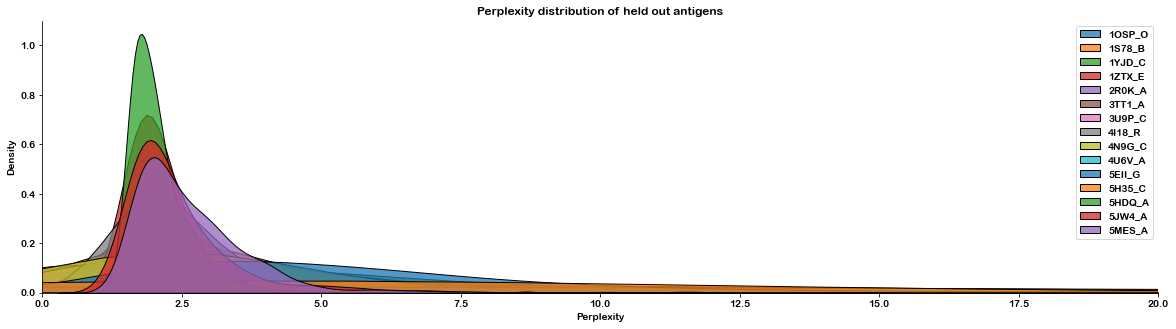

In [7]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_xlim(0,20)
for i in range(len(per_seq)):
    sns.kdeplot(per_seq[i], multiple='stack', label=a[i])
ax.legend()

ax.set_title("Perplexity distribution of held out antigens")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("Perplexity")
# ax.set_ylabel("Mean perplexity over tokens")
fig.savefig("../experiments_data/figures/Perplexity distribution of held out antigens.pdf", dpi=600)

## 2.generative testing

- Generative testing with negative log-likelihood, which will be discarded in the future.


In [9]:
# get all sequences for test
all_antibody_seqs = [data[i]['antibody_data'] for i in a]
all_antigen_seqs = [data[i]['antigen_sequence'] for i in a]

In [10]:
all_antibody_heros = []
for id in a: 
    all_antibody_heros.append(list(pd.read_table("../absolute_antibody/CDRH3_superhero/" + id + "_supers.txt", skiprows=1)['CDR3']))

In [83]:
# generate test
nlls_all = []
nature_nlls_all = []
seqs_all = []
for i in range(15):
    antigen_seq = all_antigen_seqs[i]
    antigen_seq = ' '.join(list(antigen_seq))
    antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                    return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
    s = time.time()
    generator = CDRGenerate(model=current_model,
                            antigen=antigen_encode)
    seqs, nlls = generator.generate(700, 60, p=0.95, method='top-p')
    print(f"Running time: {time.time() - s}s.")

    nature_nlls = []
    metrics = Metrics(model=current_model)
    for j in tqdm(range((len(all_antibody_heros[i])))):
        nature_nlls.append(metrics.negative_log_likelihood(all_antibody_heros[i][j][3: ], antigen=antigen_encode))
    nlls_all.append(nlls)
    seqs_all.append(seqs)
    nature_nlls_all.append(nature_nlls)


Running time: 145.1551592350006s.


100%|██████████| 725/725 [03:05<00:00,  3.91it/s]


Running time: 223.4142928123474s.


100%|██████████| 694/694 [03:55<00:00,  2.95it/s]


Running time: 140.96603226661682s.


100%|██████████| 700/700 [02:36<00:00,  4.46it/s]


Running time: 137.5344865322113s.


100%|██████████| 694/694 [02:17<00:00,  5.03it/s]


Running time: 156.3010711669922s.


100%|██████████| 718/718 [02:57<00:00,  4.05it/s]


Running time: 209.22000098228455s.


100%|██████████| 711/711 [04:05<00:00,  2.90it/s]


Running time: 138.35572695732117s.


100%|██████████| 715/715 [02:38<00:00,  4.52it/s]


Running time: 153.6578187942505s.


100%|██████████| 697/697 [02:33<00:00,  4.54it/s]


Running time: 125.78978657722473s.


100%|██████████| 711/711 [02:38<00:00,  4.47it/s]


Running time: 173.0978536605835s.


100%|██████████| 698/698 [03:17<00:00,  3.54it/s]


Running time: 134.06690621376038s.


100%|██████████| 705/705 [02:36<00:00,  4.52it/s]


Running time: 148.57889366149902s.


100%|██████████| 714/714 [02:38<00:00,  4.52it/s]


Running time: 177.94738578796387s.


100%|██████████| 900/900 [03:59<00:00,  3.76it/s]


Running time: 186.30468201637268s.


100%|██████████| 746/746 [03:30<00:00,  3.54it/s]


Running time: 144.30582356452942s.


100%|██████████| 694/694 [02:32<00:00,  4.55it/s]


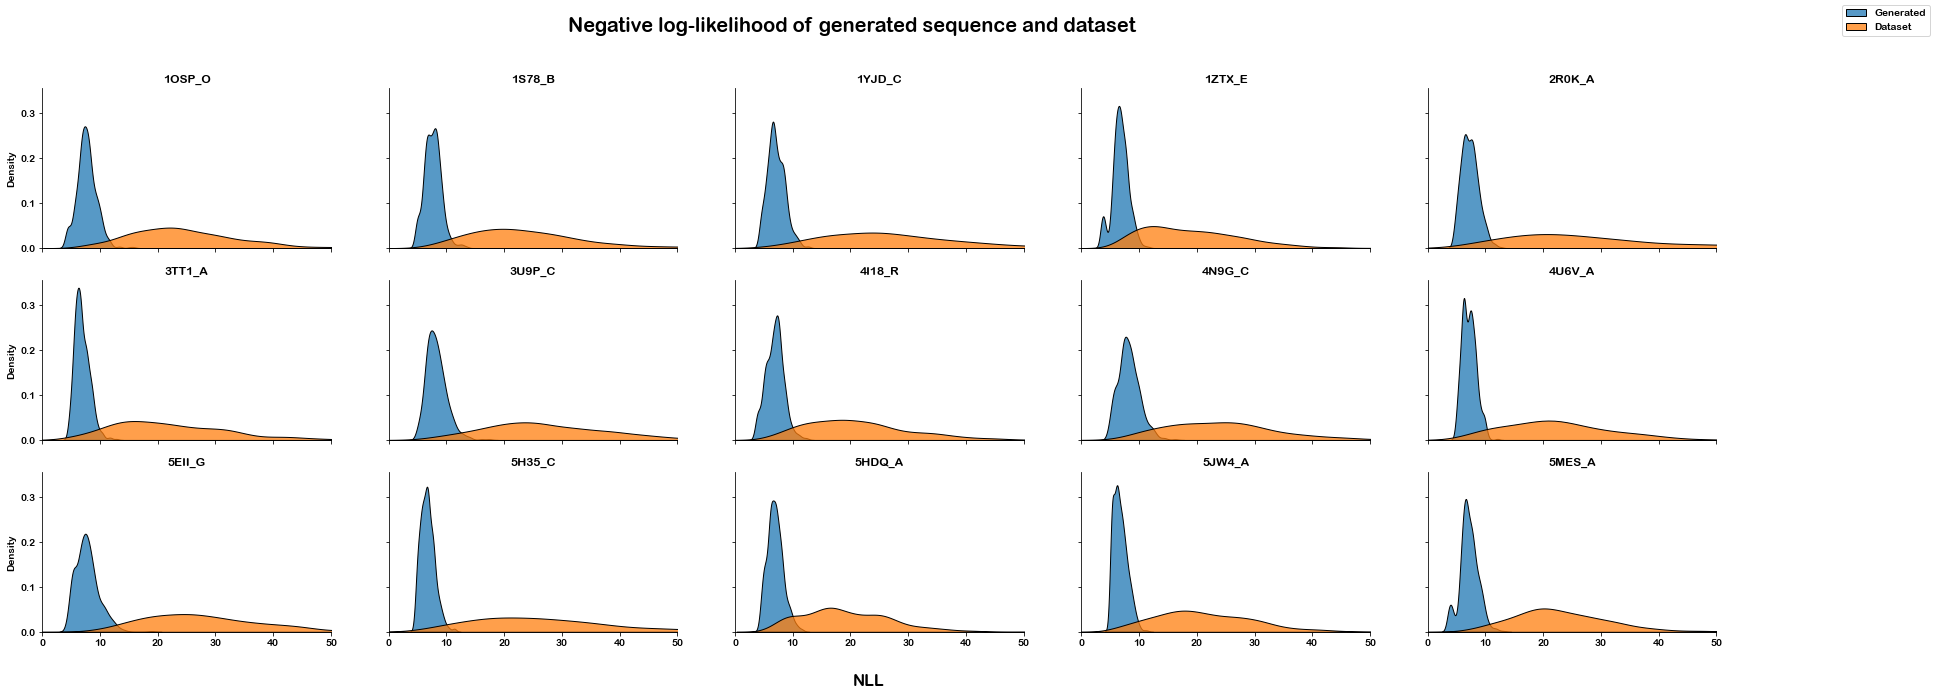

In [22]:
fig ,ax = plt.subplots(3,5, sharex=True, sharey=True, figsize=(30,10))
axs = ax.flatten()
for i in range(15):
    axs[i].set_xlim(0,50)
    sns.kdeplot(nlls_all[i], ax=axs[i], multiple='stack', label='Generated')
    sns.kdeplot(nature_nlls_all[i], ax=axs[i], multiple='stack', label='Dataset')
    axs[i].set_title(a[i])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.text(0.5, 0.05,'NLL', fontsize=16)
fig.suptitle("Negative log-likelihood of generated sequence and dataset",fontsize=20)
fig.savefig("../experiments_data/figures/Negative log-likelihood of generated sequence and dataset.pdf", dpi=600)
    

In [133]:
"""
# in-dist test 1ADQ_A
adq_ag = data['1ADQ_A']['antigen_sequence']
adg_heros = list((pd.read_table("../absolute_antibody/CDRH3_superhero/" + '1ADQ_A' + "_supers.txt", skiprows=1)['CDR3']))

antigen_seq = ' '.join(list(adq_ag))
antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
#%%
s = time.time()
generator = CDRGenerate(model=current_model,
                        antigen=antigen_encode)
seqs, nlls = generator.generate(500, 60, p=0.95, method='top-p')
print(f"Running time: {time.time() - s}s.")

nature_nlls = []
metrics = Metrics(model=current_model)
for j in tqdm(range((len(adg_heros)))):
    nature_nlls.append(metrics.negative_log_likelihood(adg_heros[j], antigen=antigen_encode))

#%%
fig, ax = plt.subplots()
sns.kdeplot(nlls)
sns.kdeplot(nature_nlls)
fig.savefig("out.pdf")
"""

## 3.GPCR

In [4]:
gpcr = 'MGAGVLVLGASEPGNLSSAAPLPDGAATAARLLVPASPPASLLPPASESPEPLSQQWTAGMGLLMALIVLLIVAGNVLVIVAIAKTPRLQTLTNLFIMSLASADLVMGLLVVPFGATIVVWGRWEYGSFFCELWTSVDVLCVTASIETLCVIALDRYLAITSPFRYQSLLTRARARGLVCTVWAISALVSFLPILMHWWRAESDEARRCYNDPKCCDFVTNRAYAIASSVVSFYVPLCIMAFVYLRVFREAQKQVKKIDSCERRFLGGPARPPSPSPSPVPAPAPPPGPPRPAAAAATAPLANGRAGKRRPSRLVALREQKALKTLGIIMGVFTLCWLPFFLANVVKAFHRELVPDRLFVFFNWLGYANSAFNPIIYCRSPDFRKAFQRLLCCARRAARRRHATHGDRPRASGCLARPGPPPSPGAASDDDDDDVVGATPPARLLEPWAGCNGGAAADSDSSLDEPCRPGFASESKV'

In [188]:
gpcr_heros = list(pd.read_csv("../experiments_data/gpcr_cdrh3.csv")['cdrh3'])
with open("gpcr.fa", 'w') as f:
    for i in gpcr_heros:
        f.write("> " + i + '\n')
        f.write(i + '\n')

In [7]:
antigen_seq = ' '.join(list(gpcr))
antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
s = time.time()
generator = CDRGenerate(model=current_model,
                        antigen=antigen_encode)
seqs, nlls = generator.generate(100, 60, p=0.95, method='top-p')
print(f"Running time: {time.time() - s}s.")

with open("gen_gpcr.fa", 'w') as f:
    for i in seqs:
        f.write("> gen" + i + '\n')
        f.write(i + '\n')



Running time: 41.39436912536621s.


In [159]:
nature_nlls = []
metrics = Metrics(model=current_model)
for j in tqdm(range((len(gpcr_heros)))):
    nature_nlls.append(metrics.negative_log_likelihood(gpcr_heros[j] + 'W', antigen=antigen_encode))

100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


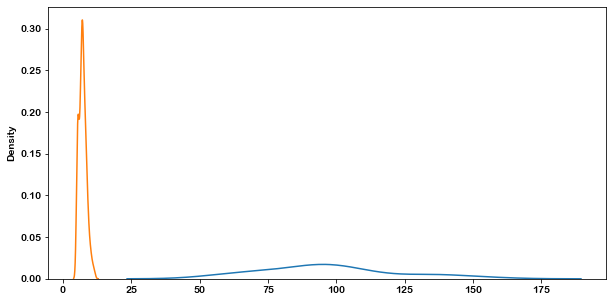

In [164]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(nature_nlls)
sns.kdeplot(nlls)
fig.savefig("../experiments_data/figures/gpcr nll distribution.pdf")

In [169]:
# seq logo of 1ADQ_A
with open("adg.fa", 'w') as f:
    for i in adg_heros:
        f.write("> " + i + '\n')
        f.write(i[3:-1] + '\n')


In [170]:
# seq logo of generated 1ADQ_A
antigen_seq = ' '.join(list(adq_ag))
antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
s = time.time()
generator = CDRGenerate(model=current_model,
                        antigen=antigen_encode)
seqs, nlls = generator.generate(500, 60, p=0.95, method='top-p')
print(f"Running time: {time.time() - s}s.")

Running time: 158.53613567352295s.


In [171]:
with open("generated_adg.fa", 'w') as f:
    for i in seqs:
        f.write("> " + i + '\n')
        f.write(i[3:-1] + '\n')

In [173]:
data.keys()

dict_keys(['1ADQ_A', '1FBI_X', '1FNS_A', '1FSK_A', '1H0D_C', '1JPS_T', '1MHP_A', '1NCA_N', '1NCB_N', '1NSN_S', '1OAZ_A', '1OB1_C', '1OSP_O', '1PKQ_J', '1RJL_C', '1S78_B', '1TQB_A', '1WEJ_F', '1YJD_C', '1ZTX_E', '2B2X_A', '2DD8_S', '2HFG_R', '2IH3_C', '2JEL_P', '2Q8A_A', '2R0K_A', '2R29_A', '2R4R_A', '2R56_A', '2UZI_R', '2VXQ_A', '2VXT_I', '2W9E_A', '2WUC_I', '2XQB_A', '2XWT_C', '2YC1_C', '2YPV_A', '2ZCH_P', '3B9K_A', '3BGF_S', '3BN9_A', '3EFD_K', '3G04_C', '3GI9_C', '3HI6_A', '3JBQ_B', '3KJ4_A', '3KR3_D', '3KS0_J', '3L5W_I', '3L5X_A', '3L95_X', '3MJ9_A', '3NCY_A', '3NFP_I', '3NH7_A', '3NPS_A', '3Q3G_E', '3R08_E', '3R1G_B', '3RAJ_A', '3RKD_A', '3RVV_A', '3SKJ_E', '3SO3_A', '3SQO_A', '3TT1_A', '3U9P_C', '3UBX_A', '3V6O_A', '3VG9_A', '3VRL_C', '3WD5_A', '4AEI_A', '4CAD_C', '4DKE_A', '4H88_A', '4HC1_B', '4Hj0_A', '4HJ0_B', '4I18_R', '4I77_Z', '4IJ3_A', '4K24_A', '4K3J_A', '4K9E_C', '4KI5_M', '4KXZ_A', '4KXZ_B', '4KXZ_E', '4LQF_A', '4LU5_B', '4M7L_T', '4MXV_B', '4N9G_C', '4NP4_A', '4OII_A',

## 4.Sequence logos!

In [177]:
"""
# split native(natural) CDRH3 sequence into fasta files 
for name in data.keys():
    logo_heros = list((pd.read_table("../absolute_antibody/CDRH3_superhero/" + name + "_supers.txt", skiprows=1)['CDR3']))
    with open("../experiments_data/seq_logo_files/" + name + ".fa", 'w') as f:
        for i in range(len(logo_heros)):
            f.write("> " + str(i) + '\n')
            f.write(logo_heros[i][3:-1] + '\n')
"""

In [20]:
for i, pdb in enumerate(a):
    print(f"Executing pdb: {pdb}, order: {i+1}")
    ag_seq = data[pdb]['antigen_sequence']
    antigen_encode = get_antigen_embedding(ag_seq)
    # generator = CDRGenerate(model=current_model, antigen=antigen_encode)
    # seqs, nlls = generator.generate(500, 60, p=0.95, method='top-p')
    seqs = seqs_all[i]

    with open("../experiments_data/seq_logo_files/" + pdb + ".fa", 'a') as f:
        for i,j in enumerate(seqs):
            f.write("> " + str(i) + '_generated\n')
            f.write(j[:-1] + '\n')
    # break


Executing pdb: 1OSP_O, order: 1
Executing pdb: 1S78_B, order: 2
Executing pdb: 1YJD_C, order: 3
Executing pdb: 1ZTX_E, order: 4
Executing pdb: 2R0K_A, order: 5
Executing pdb: 3TT1_A, order: 6
Executing pdb: 3U9P_C, order: 7
Executing pdb: 4I18_R, order: 8
Executing pdb: 4N9G_C, order: 9
Executing pdb: 4U6V_A, order: 10
Executing pdb: 5EII_G, order: 11
Executing pdb: 5H35_C, order: 12
Executing pdb: 5HDQ_A, order: 13
Executing pdb: 5JW4_A, order: 14
Executing pdb: 5MES_A, order: 15


In [13]:
# generation with id
def generaion_with_id(pdb):
    ag_seq = data[pdb]['antigen_sequence']
    antigen_encode = get_antigen_embedding(ag_seq, batched=False)
    generator = CDRGenerate(model=current_model, antigen=antigen_encode)
    seqs, _ = generator.generate(700, 60, p=0.95, method='top-p')

    with open("../experiments_data/seq_logo_files/" + pdb + ".fa", 'a') as f:
        for i,j in enumerate(seqs):
            f.write("> " + str(i) + '_generated\n')
            f.write(j[:-1] + '\n')

In [19]:
generaion_with_id('4PP1_A')

## 5.Attention score analysis

- Analysis of attention score of cross-attention part
- 1ADQ as example (first attempt)

In [37]:
ag_1adq = data['1YJD_C']['antigen_sequence']
seq_1adq = ' '.join(list(ag_1adq))
antigen_encode_1adq = pretrained_model(**tokenizer(seq_1adq,
                                                return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach().unsqueeze(0)  # [batch, length, dim]
heros_1adq = list((pd.read_table("../absolute_antibody/CDRH3_superhero/" + '1ADQ_A' + "_supers.txt", skiprows=1)['CDR3']))

# use the first one to test 
cdrh3 = get_antibody_tokens(heros_1adq[0])

In [38]:
_, attention_1adq = current_model.forward((antigen_encode_1adq, cdrh3, None))

In [39]:
attention_score = attention_1adq[0,0,:,:].detach().numpy()

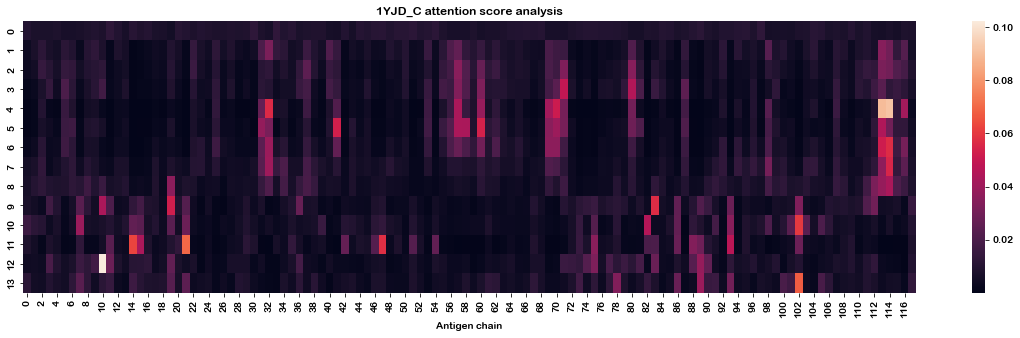

In [43]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(attention_score)
ax.set_xlabel("Antigen chain")
ax.set_title("1YJD_C attention score analysis")
fig.savefig("../experiments_data/figures/1YJD_C attention score analysis.pdf", dpi=600)

In [42]:
np.where(attention_score > 0.08)

(array([ 4,  4, 12], dtype=int64), array([113, 114,  10], dtype=int64))

## 6.Embedding analysis

In [20]:
# split alignment file

# import os
# for i in os.listdir():
#     f1 = open(i[:6] + "_native.txt", 'w')
#     f2 = open(i[:6] + "_generated.txt", 'w')
#     all_lines = open(i, 'r').readlines()
#     for j in range(0, len(all_lines), 2):
#         if 'generated' in all_lines[j]:
#             f2.write(">" + str(j) + "\n")
#             f2.write(all_lines[j + 1])
#         else:
#             f1.write(">" + str(j) + "\n")
#             f1.write(all_lines[j + 1])
#     f1.close()
#     f2.close()
    

In [28]:
238+164

402